In [1]:
!pip install grad-cam
# Downgrade NumPy and reinstall matplotlib to ensure they are synced
!pip install "numpy<2" "matplotlib>=3.8" --force-reinstall

import torch
import torch.nn as nn
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from tqdm import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.model_selection import StratifiedGroupKFold

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 85.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.18.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.8 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incomp

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}\n")

# Paths
DATASET_ROOT = "/kaggle/input/odir5k/data/odir5k"
PATH_EFF = '/kaggle/input/efnetv4-and-mobnet/other/default/1/efficientnet_v4_best.pth'
PATH_MOB = '/kaggle/input/efnetv4-and-mobnet/other/default/1/efficientnet_mobilenetv3_large_best.pth'

class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

🖥️  Device: cuda



In [3]:
class ApplyCLAHEandCrop_Adaptive(object):
    """Adaptive CLAHE preprocessing with automatic cropping"""
    
    def __init__(self):
        self.contrast_threshold = 50
        self.clip_limit = 3.0
        self.tile_grid_size = (8, 8)
    
    def __call__(self, img):
        img = np.array(img)
        
        # Cropping (remove black borders)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray > 10
        
        if np.any(mask):
            coords = np.argwhere(mask)
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img = img[y0:y1, x0:x1]
        
        # CLAHE (only if low contrast)
        gray_cropped = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        contrast = gray_cropped.std()
        
        if contrast < self.contrast_threshold:
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            l = clahe.apply(l)
            
            img = cv2.merge([l, a, b])
            img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        
        return Image.fromarray(img)

In [4]:
def get_train_transform():
    """Training transform with augmentation"""
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_transform():
    """Validation/Test transform without augmentation"""
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [5]:
class ODIRDataset(Dataset):
    """Dataset ODIR-5K usando estrutura de pastas"""
    
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(DATASET_ROOT, split)
        
        # Carregar metadados
        metadata_path = os.path.join(self.img_dir, f"{split}_metadata.csv")
        self.data = pd.read_csv(metadata_path)
        self.disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
        self.image_files = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]
        
        print(f"  📂 {split}: {len(self.data)} pacients, {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        patient_id = str(row['ID'])
        
        img_path = None
        for side in ['left', 'right']:
            img_name = f"{patient_id}_{side}.jpg"
            full_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(full_path):
                img_path = full_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Imagem não encontrada para ID {patient_id}")
        
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor([row[col] for col in self.disease_cols], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels, patient_id

In [6]:
class EnsembleNet(nn.Module):
    def __init__(self, model_eff, model_mob, num_classes=8):
        super(EnsembleNet, self).__init__()
        # remover classifier original de ambos (mantendo apenas as features)
        self.backbone_eff = nn.Sequential(*list(model_eff.children())[:-1])
        self.backbone_mob = nn.Sequential(*list(model_mob.children())[:-1])
        
        # 1280 de cada um = 2560 features
        self.classifier = nn.Sequential(
            nn.Linear(1280 + 1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feat_eff = self.backbone_eff(x).flatten(1)
        feat_mob = self.backbone_mob(x).flatten(1)
        
        combined = torch.cat((feat_eff, feat_mob), dim=1)
        return self.classifier(combined)

In [7]:
print("="*80)
print("LOADING BASE MODELS & CREATING ENSEMBLE")
print("="*80)

def clean_state_dict(state_dict):
    """Remove 'model.' prefix from checkpoint keys"""
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']
    
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k[6:] if k.startswith('model.') else k
        new_state_dict[name] = v
    return new_state_dict

# Load base models
base_eff = timm.create_model('efficientnet_b0', pretrained=False, num_classes=8)
base_mob = timm.create_model('mobilenetv3_large_100', pretrained=False, num_classes=8)

checkpoint_eff = torch.load(PATH_EFF, map_location=device)
checkpoint_mob = torch.load(PATH_MOB, map_location=device)

eff_weights = clean_state_dict(checkpoint_eff)
mob_weights = clean_state_dict(checkpoint_mob)

base_eff.load_state_dict(eff_weights, strict=False)
base_mob.load_state_dict(mob_weights, strict=False)

print("✅ Base models loaded")

# Create ensemble
model = EnsembleNet(base_eff, base_mob, num_classes=8).to(device)
print(f"✅ EnsembleNet created: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters\n")

LOADING BASE MODELS & CREATING ENSEMBLE
✅ Base models loaded
✅ EnsembleNet created: 9.5M parameters



In [8]:
print("="*80)
print("CREATING DATASETS & DATALOADERS")
print("="*80)

train_dataset = ODIRDataset('train', transform=get_train_transform())
val_dataset = ODIRDataset('val', transform=get_val_transform())
test_dataset = ODIRDataset('test', transform=get_val_transform())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✅ Dataloaders created\n")

CREATING DATASETS & DATALOADERS
  📂 train: 4474 pacients, 5732 images
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images

✅ Dataloaders created



In [9]:
if not os.path.exists('/kaggle/working/ensemblenet_best.pth'):
    print("="*80)
    print("TRAINING ENSEMBLE")
    print("="*80)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-7
    )
    
    num_epochs = 40
    best_val_f1 = 0
    patience = 15
    patience_counter = 0
    
    print(f"\n📋 Config: {num_epochs} epochs, LR=1e-4, patience={patience}\n")
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        
        for imgs, labels, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Train'):
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for imgs, labels, _ in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Val'):
                imgs = imgs.to(device)
                outputs = model(imgs)
                preds = (torch.sigmoid(outputs) > 0.5).int()
                
                val_preds.append(preds.cpu().numpy())
                val_labels.append(labels.numpy())
        
        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
        
        scheduler.step(val_f1)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'val_f1': val_f1
            }, '/kaggle/working/ensemblenet_best.pth')
            print(f"  ✅ New best! Saved.")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement ({patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping")
            break
    
    print(f"\n✅ Training complete! Best Val F1: {best_val_f1:.4f}\n")

TRAINING ENSEMBLE

📋 Config: 40 epochs, LR=1e-4, patience=15



Epoch 1/40 - Val: 100%|██████████| 30/30 [00:15<00:00,  2.00it/s]



Epoch 1/40:
  Loss: 0.2399 | Val F1: 0.8195 | LR: 0.000100
  ✅ New best! Saved.


Epoch 2/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]



Epoch 2/40:
  Loss: 0.0722 | Val F1: 0.8321 | LR: 0.000100
  ✅ New best! Saved.


Epoch 3/40 - Val: 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]



Epoch 3/40:
  Loss: 0.0454 | Val F1: 0.8359 | LR: 0.000100
  ✅ New best! Saved.


Epoch 4/40 - Val: 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]



Epoch 4/40:
  Loss: 0.0327 | Val F1: 0.8466 | LR: 0.000100
  ✅ New best! Saved.


Epoch 5/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]



Epoch 5/40:
  Loss: 0.0259 | Val F1: 0.8354 | LR: 0.000100
  ⏳ No improvement (1/15)


Epoch 6/40 - Val: 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]



Epoch 6/40:
  Loss: 0.0240 | Val F1: 0.8331 | LR: 0.000100
  ⏳ No improvement (2/15)


Epoch 7/40 - Val: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]



Epoch 7/40:
  Loss: 0.0223 | Val F1: 0.8410 | LR: 0.000100
  ⏳ No improvement (3/15)


Epoch 8/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]



Epoch 8/40:
  Loss: 0.0185 | Val F1: 0.8447 | LR: 0.000100
  ⏳ No improvement (4/15)


Epoch 9/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]



Epoch 9/40:
  Loss: 0.0165 | Val F1: 0.8382 | LR: 0.000100
  ⏳ No improvement (5/15)


Epoch 10/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.34it/s]



Epoch 10/40:
  Loss: 0.0143 | Val F1: 0.8413 | LR: 0.000050
  ⏳ No improvement (6/15)


Epoch 11/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.32it/s]



Epoch 11/40:
  Loss: 0.0131 | Val F1: 0.8423 | LR: 0.000050
  ⏳ No improvement (7/15)


Epoch 12/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]



Epoch 12/40:
  Loss: 0.0113 | Val F1: 0.8394 | LR: 0.000050
  ⏳ No improvement (8/15)


Epoch 13/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]



Epoch 13/40:
  Loss: 0.0084 | Val F1: 0.8413 | LR: 0.000050
  ⏳ No improvement (9/15)


Epoch 14/40 - Val: 100%|██████████| 30/30 [00:13<00:00,  2.31it/s]



Epoch 14/40:
  Loss: 0.0076 | Val F1: 0.8462 | LR: 0.000050
  ⏳ No improvement (10/15)


Epoch 15/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]



Epoch 15/40:
  Loss: 0.0082 | Val F1: 0.8439 | LR: 0.000050
  ⏳ No improvement (11/15)


Epoch 16/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]



Epoch 16/40:
  Loss: 0.0063 | Val F1: 0.8417 | LR: 0.000025
  ⏳ No improvement (12/15)


Epoch 17/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]



Epoch 17/40:
  Loss: 0.0061 | Val F1: 0.8407 | LR: 0.000025
  ⏳ No improvement (13/15)


Epoch 18/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]



Epoch 18/40:
  Loss: 0.0060 | Val F1: 0.8400 | LR: 0.000025
  ⏳ No improvement (14/15)


Epoch 19/40 - Val: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch 19/40:
  Loss: 0.0068 | Val F1: 0.8436 | LR: 0.000025
  ⏳ No improvement (15/15)

⏹️  Early stopping

✅ Training complete! Best Val F1: 0.8466



In [10]:
print("="*80)
print("EVALUATING ON TEST SET")
print("="*80)

checkpoint = torch.load('/kaggle/working/ensemblenet_best.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\n✅ Loaded best model (Val F1: {checkpoint['val_f1']:.4f})")

# Generate predictions
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels, _ in tqdm(test_loader, desc='Testing'):
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        
        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.numpy())

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Metrics
test_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)

print(f"\n{'='*80}")
print(f"🏆 TEST RESULTS")
print(f"{'='*80}")
print(f"Test F1 (Macro): {test_f1_macro:.4f}\n")
print(f"Per-Class F1:")
for i, name in enumerate(class_names):
    print(f"  {name}: {per_class_f1[i]:.4f}")
print(f"{'='*80}\n")

EVALUATING ON TEST SET

✅ Loaded best model (Val F1: 0.8466)


Testing: 100%|██████████| 30/30 [00:15<00:00,  2.00it/s]


🏆 TEST RESULTS
Test F1 (Macro): 0.8430

Per-Class F1:
  N: 0.8585
  D: 0.8722
  G: 0.8065
  C: 0.8772
  A: 0.8222
  H: 0.7887
  M: 0.9268
  O: 0.7921



GENERATING VISUALIZATIONS



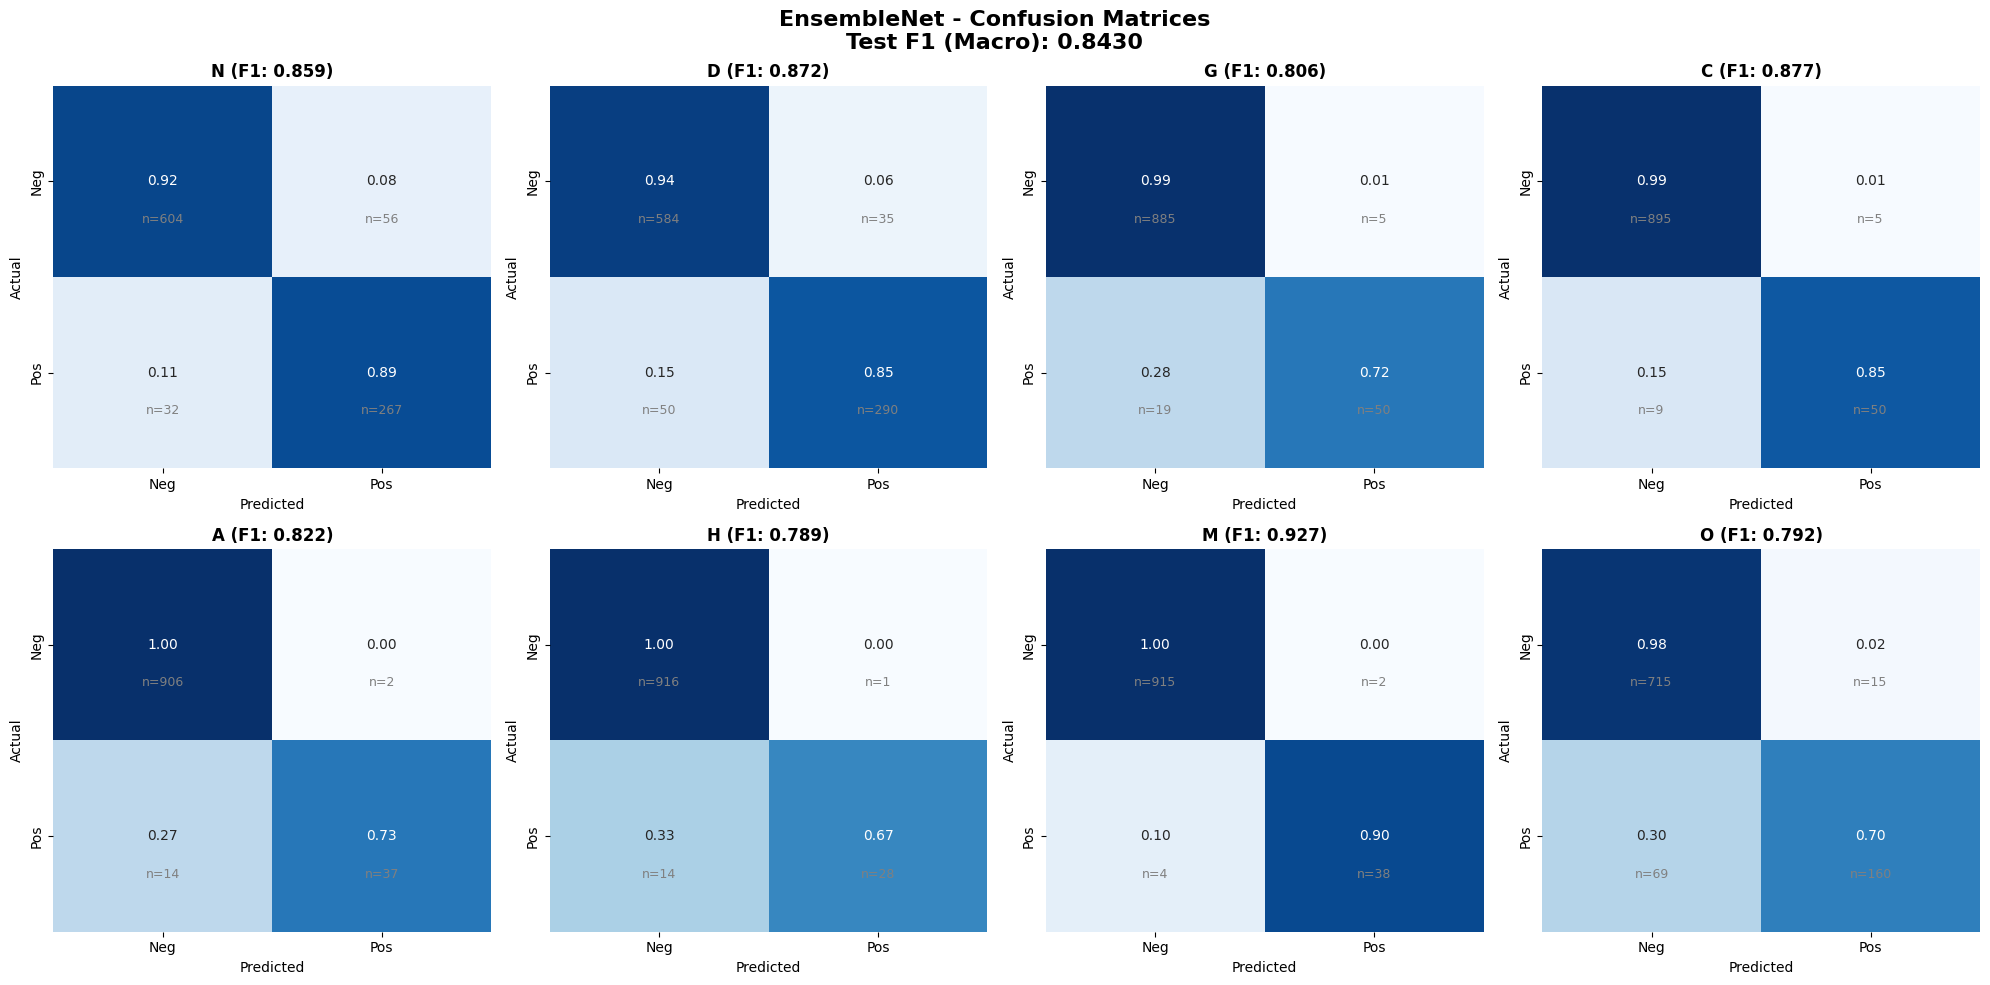

✅ Saved: ensemble_confusion_matrices.png


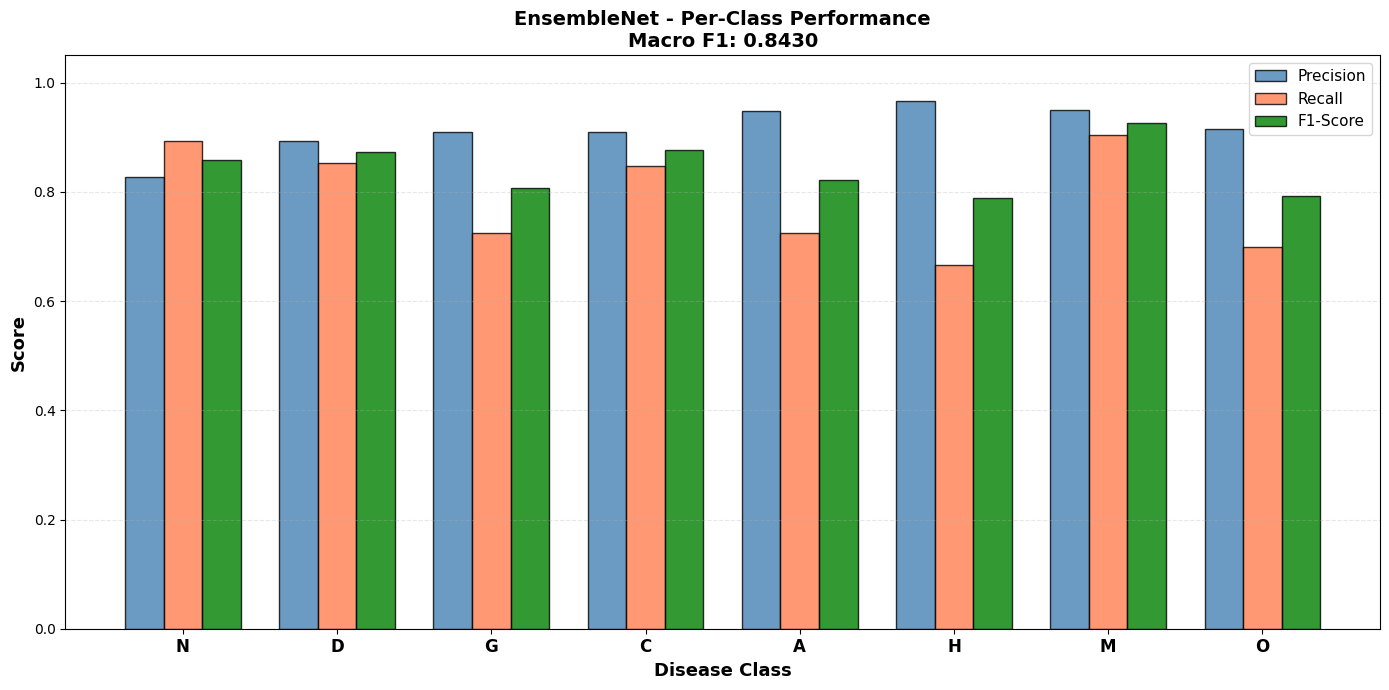

✅ Saved: ensemble_perclass_metrics.png


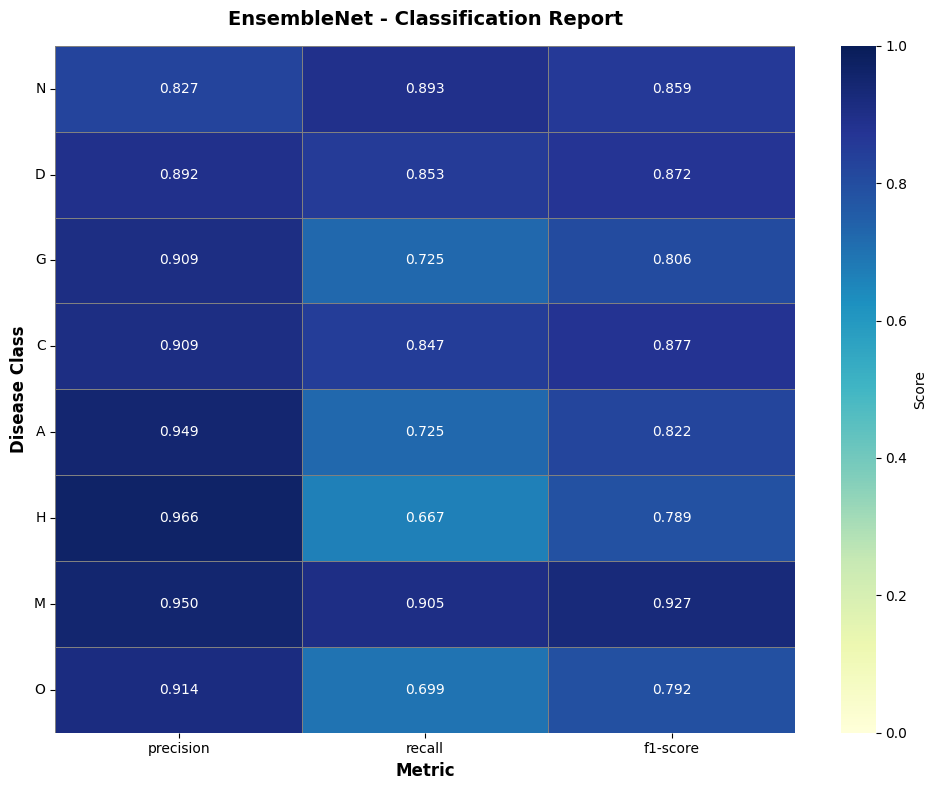

✅ Saved: ensemble_classification_report.png


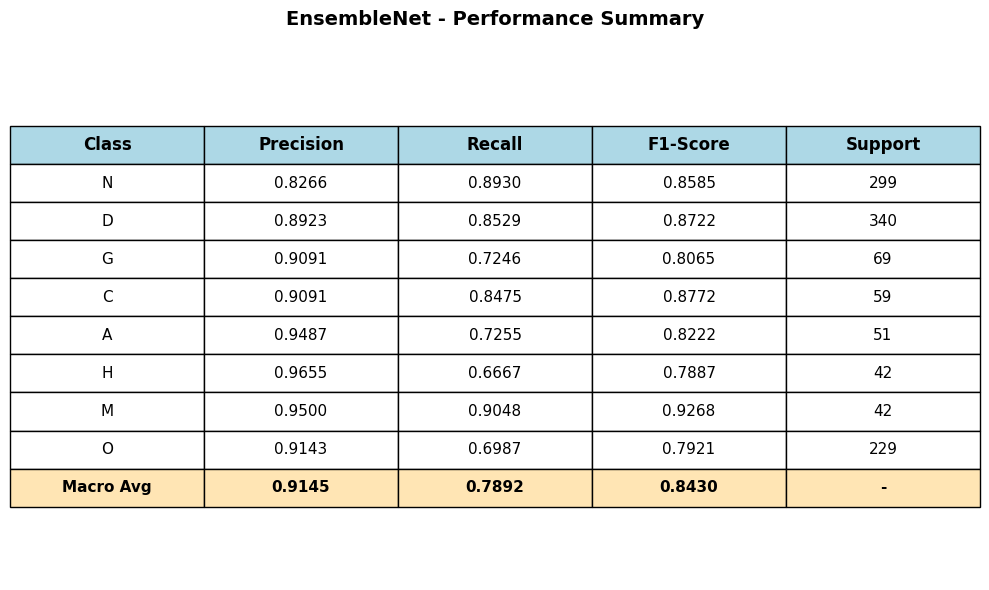

✅ Saved: ensemble_summary_table.png


In [11]:
print("="*80)
print("GENERATING VISUALIZATIONS")
print("="*80 + "\n")

# PLOT 1: Confusion Matrices (2×4 grid)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
fig.suptitle(f'EnsembleNet - Confusion Matrices\nTest F1 (Macro): {test_f1_macro:.4f}',
             fontsize=16, fontweight='bold')

for i, (ax, class_name) in enumerate(zip(axes, class_names)):
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'],
                vmin=0, vmax=1, cbar=False)
    
    ax.set_title(f'{class_name} (F1: {per_class_f1[i]:.3f})', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # Add counts
    for j in range(2):
        for k in range(2):
            ax.text(k+0.5, j+0.7, f'n={cm[j,k]}',
                   ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('/kaggle/working/ensemble_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: ensemble_confusion_matrices.png")

# PLOT 2: Per-Class Metrics (Bar Chart)
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, per_class_precision, width, label='Precision', color='steelblue', alpha=0.8, edgecolor='black')
ax.bar(x, per_class_recall, width, label='Recall', color='coral', alpha=0.8, edgecolor='black')
ax.bar(x + width, per_class_f1, width, label='F1-Score', color='green', alpha=0.8, edgecolor='black')

ax.set_xlabel('Disease Class', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title(f'EnsembleNet - Per-Class Performance\nMacro F1: {test_f1_macro:.4f}',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('/kaggle/working/ensemble_perclass_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: ensemble_perclass_metrics.png")

# PLOT 3: Classification Report (Heatmap)
report = classification_report(all_labels, all_preds, target_names=class_names,
                              output_dict=True, zero_division=0)

df_report = pd.DataFrame(report).transpose()
df_plot = df_report.iloc[:8]

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_plot[['precision', 'recall', 'f1-score']], 
            annot=True, fmt='.3f', cmap='YlGnBu', ax=ax,
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1,
            linewidths=0.5, linecolor='gray')

ax.set_title('EnsembleNet - Classification Report',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Disease Class', fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('/kaggle/working/ensemble_classification_report.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: ensemble_classification_report.png")

# PLOT 4: Summary Table
summary_data = []
for i, name in enumerate(class_names):
    summary_data.append({
        'Class': name,
        'Precision': f"{per_class_precision[i]:.4f}",
        'Recall': f"{per_class_recall[i]:.4f}",
        'F1-Score': f"{per_class_f1[i]:.4f}",
        'Support': int(all_labels[:, i].sum())
    })

summary_data.append({
    'Class': 'Macro Avg',
    'Precision': f"{precision_score(all_labels, all_preds, average='macro', zero_division=0):.4f}",
    'Recall': f"{recall_score(all_labels, all_preds, average='macro', zero_division=0):.4f}",
    'F1-Score': f"{test_f1_macro:.4f}",
    'Support': '-'
})

df_summary = pd.DataFrame(summary_data)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_summary.values, colLabels=df_summary.columns,
                cellLoc='center', loc='center', colColours=['lightblue']*5)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

for i in range(5):
    table[(0, i)].set_text_props(weight='bold', fontsize=12)
    table[(9, i)].set_facecolor('#FFE5B4')
    table[(9, i)].set_text_props(weight='bold')

ax.set_title('EnsembleNet - Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('/kaggle/working/ensemble_summary_table.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: ensemble_summary_table.png")

In [12]:
# CSV
df_summary.to_csv('/kaggle/working/ensemble_results.csv', index=False)
print("✅ Saved: ensemble_results.csv")

# JSON
results_json = {
    'model': 'EnsembleNet (EfficientNet-B0 + MobileNetV3-Large)',
    'test_f1_macro': float(test_f1_macro),
    'test_precision_macro': float(precision_score(all_labels, all_preds, average='macro', zero_division=0)),
    'test_recall_macro': float(recall_score(all_labels, all_preds, average='macro', zero_division=0)),
    'per_class': {
        class_names[i]: {
            'precision': float(per_class_precision[i]),
            'recall': float(per_class_recall[i]),
            'f1_score': float(per_class_f1[i]),
            'support': int(all_labels[:, i].sum())
        } for i in range(len(class_names))
    }
}

with open('/kaggle/working/ensemble_results.json', 'w') as f:
    json.dump(results_json, f, indent=2)
print("✅ Saved: ensemble_results.json")

✅ Saved: ensemble_results.csv
✅ Saved: ensemble_results.json


In [13]:
#XAI
def generate_ensemble_xai(model, test_loader, device, 
                          target_layers, version_name='Ensemble',
                          max_cases_per_type=3):
    """
    Gera visualizações Grad-CAM para o Ensemble (EffNet + MobileNet)
    """
    model.eval()
    cam = GradCAM(model=model, target_layers=target_layers)
    class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    xai_data_for_report = []
    counts = {"SUCCESS": 0, "FAILURE": 0}
    
    print(f"\n{'='*80}\nGenerating Grad-CAM visualizations for {version_name}\n{'='*80}")
    
    for imgs, labels, img_ids in tqdm(test_loader, desc='Processing XAI'):
        imgs_dev = imgs.to(device)
        
        with torch.no_grad():
            outputs = model(imgs_dev)
            probs = torch.sigmoid(outputs)
        
        preds = (probs > 0.5).int().cpu().numpy()
        labels_np = labels.numpy()
        probs_np = probs.cpu().numpy()
        
        for i in range(imgs.shape[0]):
            is_correct = np.array_equal(preds[i], labels_np[i])
            case_type = "SUCCESS" if is_correct else "FAILURE"
            
            if counts[case_type] >= max_cases_per_type:
                continue
            
            gt_classes = np.where(labels_np[i] == 1)[0]
            if len(gt_classes) == 0: continue 
            
            # Grad-CAM foca na classe real mais confiante
            target_class_idx = gt_classes[np.argmax(probs_np[i][gt_classes])]
            targets = [ClassifierOutputTarget(target_class_idx)]
            
            # Gerar Cam
            grayscale_cam = cam(input_tensor=imgs_dev[i:i+1], targets=targets)[0, :]
            
            # Denormalizar para visualização
            img_original = imgs[i].permute(1, 2, 0).numpy()
            img_min, img_max = img_original.min(), img_original.max()
            img_original = (img_original - img_min) / (img_max - img_min + 1e-8)
            
            visualization = show_cam_on_image(img_original, grayscale_cam, use_rgb=True)
            
            # Plot e Save
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))
            axes[0].imshow(img_original); axes[0].set_title(f"Original - ID: {img_ids[i]}"); axes[0].axis('off')
            axes[1].imshow(grayscale_cam, cmap='jet'); axes[1].set_title(f"Heatmap - Target: {class_names[target_class_idx]}"); axes[1].axis('off')
            
            gt_str = ', '.join([class_names[j] for j in gt_classes])
            pred_classes = np.where(preds[i] == 1)[0]
            pred_str = ', '.join([class_names[j] for j in pred_classes]) if len(pred_classes) > 0 else 'None'
            
            title = f"Overlay {case_type}\nGT: {gt_str}\nPred: {pred_str}\nConf: {probs_np[i][target_class_idx]:.3f}"
            axes[2].imshow(visualization); axes[2].set_title(title); axes[2].axis('off')
            
            filename = f"xai_{version_name.lower()}_{case_type.lower()}_case{counts[case_type]+1}.png"
            plt.savefig(f'/kaggle/working/{filename}', dpi=150, bbox_inches='tight')
            plt.close()
            
            counts[case_type] += 1
            print(f"  ✅ Saved: {filename}")

        if counts["SUCCESS"] >= max_cases_per_type and counts["FAILURE"] >= max_cases_per_type:
            break

# Configuração e Execução
target_layers = [model.backbone_eff[4], model.backbone_mob[2][6]]
xai_test_loader = torch.utils.data.DataLoader(ODIRDataset('test', transform=get_val_transform()), 
                                              batch_size=16, shuffle=False)

generate_ensemble_xai(model, xai_test_loader, device, target_layers, max_cases_per_type=5)

  📂 test: 959 pacients, 1748 images

Generating Grad-CAM visualizations for Ensemble


Processing XAI:   0%|          | 0/60 [00:00<?, ?it/s]

  ✅ Saved: xai_ensemble_success_case1.png
  ✅ Saved: xai_ensemble_success_case2.png
  ✅ Saved: xai_ensemble_success_case3.png
  ✅ Saved: xai_ensemble_success_case4.png
  ✅ Saved: xai_ensemble_success_case5.png


Processing XAI:   2%|▏         | 1/60 [00:04<04:45,  4.84s/it]

  ✅ Saved: xai_ensemble_failure_case1.png


Processing XAI:   3%|▎         | 2/60 [00:05<02:06,  2.18s/it]

  ✅ Saved: xai_ensemble_failure_case2.png
  ✅ Saved: xai_ensemble_failure_case3.png
  ✅ Saved: xai_ensemble_failure_case4.png


Processing XAI:   3%|▎         | 2/60 [00:07<03:49,  3.95s/it]

  ✅ Saved: xai_ensemble_failure_case5.png


In [14]:
## Functions used in k-Fold
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    
    for imgs, labels, _ in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
    
    return running_loss / len(loader.dataset)

def validate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels, _ in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            # Como é ODIR (multi-label), usamos sigmoid + threshold 0.5
            preds = (torch.sigmoid(outputs) > 0.5).int()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
    
    # Concatenar todos os batches
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calcular Macro F1 (importante para classes desequilibradas como O e H)
    from sklearn.metrics import f1_score
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return val_f1, None

In [15]:
def train_ensemble_fold(model, train_loader, val_loader, fold_num, device, num_epochs=15):
    """Train one fold with proper multi-label loss and metrics"""
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
    )
    
    best_val_f1 = 0
    patience = 5
    patience_counter = 0
    
    history = {
        'train_loss': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }
    
    print(f"\n{'='*60}")
    print(f"🚀 TRAINING FOLD {fold_num}")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        # ========== TRAIN ==========
        model.train()
        running_loss = 0.0
        
        for imgs, labels, _ in tqdm(train_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{num_epochs} - Train', leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        
        # ========== VALIDATION ==========
        model.eval()
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for imgs, labels, _ in tqdm(val_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{num_epochs} - Val', leave=False):
                imgs = imgs.to(device)
                outputs = model(imgs)
                preds = (torch.sigmoid(outputs) > 0.5).int()
                
                val_preds.append(preds.cpu().numpy())
                val_labels.append(labels.numpy())
        
        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
        
        scheduler.step(val_f1)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        
        print(f"  Epoch {epoch+1}: Loss={train_loss:.4f}, F1={val_f1:.4f}, P={val_precision:.4f}, R={val_recall:.4f}")
        
        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_precision = val_precision
            best_recall = val_recall
            torch.save(model.state_dict(), f'/kaggle/working/fold_{fold_num}_best.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  ⏹️  Early stopping at epoch {epoch+1}")
                break
    
    print(f"✅ Fold {fold_num} complete! Best Val F1: {best_val_f1:.4f}")
    
    return {
        'fold': fold_num,
        'val_f1': best_val_f1,
        'val_precision': best_precision,
        'val_recall': best_recall,
        'history': history
    }

In [16]:
full_train_dataset = ODIRDataset('train', transform=get_train_transform())
indices = np.arange(len(full_train_dataset))
all_labels = full_train_dataset.data[full_train_dataset.disease_cols].values
labels_for_stratify = np.argmax(all_labels, axis=1)

patient_groups = full_train_dataset.data['ID'].values 

n_splits = 5
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

  📂 train: 4474 pacients, 5732 images


In [17]:
results_per_fold = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(sgkf.split(indices, labels_for_stratify, groups=patient_groups), 1):
    print(f"\n{'='*80}")
    print(f"🚀 STARTING FOLD {fold}/5")
    print(f"{'='*80}")
    
    # Criar subsets
    train_sub = torch.utils.data.Subset(full_train_dataset, train_idx)
    val_sub = torch.utils.data.Subset(full_train_dataset, val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_sub, batch_size=32, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_sub, batch_size=32, shuffle=False, num_workers=2)
    
    base_eff_fold = timm.create_model('efficientnet_b0', pretrained=False, num_classes=8)
    base_mob_fold = timm.create_model('mobilenetv3_large_100', pretrained=False, num_classes=8)
    
    base_eff_fold.load_state_dict(eff_weights, strict=False)
    base_mob_fold.load_state_dict(mob_weights, strict=False)
    
    model_fold = EnsembleNet(base_eff_fold, base_mob_fold, num_classes=8).to(device)
    
    fold_results = train_ensemble_fold(model_fold, train_loader, val_loader, fold, device, num_epochs=15)
    
    results_per_fold.append(fold_results)
    
    del model_fold, base_eff_fold, base_mob_fold
    torch.cuda.empty_cache()


🚀 STARTING FOLD 1/5

🚀 TRAINING FOLD 1


  Epoch 1: Loss=0.2892, F1=0.9905, P=0.9951, R=0.9863


  Epoch 2: Loss=0.0934, F1=0.9740, P=0.9976, R=0.9522


  Epoch 3: Loss=0.0565, F1=0.9711, P=0.9978, R=0.9473


  Epoch 4: Loss=0.0416, F1=0.9769, P=0.9946, R=0.9606


  Epoch 5: Loss=0.0321, F1=0.9804, P=0.9995, R=0.9627


  Epoch 6: Loss=0.0255, F1=0.9779, P=0.9955, R=0.9616
  ⏹️  Early stopping at epoch 6
✅ Fold 1 complete! Best Val F1: 0.9905

🚀 STARTING FOLD 2/5

🚀 TRAINING FOLD 2


  Epoch 1: Loss=0.2456, F1=0.9870, P=0.9964, R=0.9779


  Epoch 2: Loss=0.0808, F1=0.9746, P=0.9995, R=0.9518


  Epoch 3: Loss=0.0495, F1=0.9804, P=1.0000, R=0.9625


  Epoch 4: Loss=0.0352, F1=0.9768, P=0.9996, R=0.9559


  Epoch 5: Loss=0.0276, F1=0.9706, P=0.9980, R=0.9465


  Epoch 6: Loss=0.0228, F1=0.9793, P=0.9995, R=0.9606
  ⏹️  Early stopping at epoch 6
✅ Fold 2 complete! Best Val F1: 0.9870

🚀 STARTING FOLD 3/5

🚀 TRAINING FOLD 3


  Epoch 1: Loss=0.2414, F1=0.9894, P=0.9990, R=0.9806


  Epoch 2: Loss=0.0780, F1=0.9807, P=1.0000, R=0.9630


  Epoch 3: Loss=0.0483, F1=0.9641, P=0.9848, R=0.9458


  Epoch 4: Loss=0.0359, F1=0.9816, P=0.9988, R=0.9660


  Epoch 5: Loss=0.0296, F1=0.9768, P=0.9988, R=0.9572


  Epoch 6: Loss=0.0252, F1=0.9773, P=0.9875, R=0.9681
  ⏹️  Early stopping at epoch 6
✅ Fold 3 complete! Best Val F1: 0.9894

🚀 STARTING FOLD 4/5

🚀 TRAINING FOLD 4


  Epoch 1: Loss=0.2527, F1=0.9843, P=0.9968, R=0.9727


  Epoch 2: Loss=0.0855, F1=0.9822, P=0.9994, R=0.9661


  Epoch 3: Loss=0.0492, F1=0.9844, P=1.0000, R=0.9701


  Epoch 4: Loss=0.0357, F1=0.9860, P=0.9975, R=0.9753


  Epoch 5: Loss=0.0307, F1=0.9865, P=0.9946, R=0.9789


  Epoch 6: Loss=0.0248, F1=0.9872, P=0.9994, R=0.9757


  Epoch 7: Loss=0.0220, F1=0.9768, P=0.9924, R=0.9625


  Epoch 8: Loss=0.0220, F1=0.9828, P=0.9978, R=0.9687


  Epoch 9: Loss=0.0164, F1=0.9813, P=0.9927, R=0.9705


  Epoch 10: Loss=0.0171, F1=0.9802, P=0.9957, R=0.9654


  Epoch 11: Loss=0.0135, F1=0.9799, P=0.9976, R=0.9633
  ⏹️  Early stopping at epoch 11
✅ Fold 4 complete! Best Val F1: 0.9872

🚀 STARTING FOLD 5/5

🚀 TRAINING FOLD 5


  Epoch 1: Loss=0.2380, F1=0.9774, P=0.9945, R=0.9619


  Epoch 2: Loss=0.0787, F1=0.9757, P=0.9900, R=0.9629


  Epoch 3: Loss=0.0462, F1=0.9757, P=0.9994, R=0.9555


  Epoch 4: Loss=0.0376, F1=0.9668, P=0.9934, R=0.9433


  Epoch 5: Loss=0.0278, F1=0.9659, P=0.9889, R=0.9452


  Epoch 6: Loss=0.0229, F1=0.9726, P=1.0000, R=0.9491
  ⏹️  Early stopping at epoch 6
✅ Fold 5 complete! Best Val F1: 0.9774


In [18]:
df_results = pd.DataFrame([
    {
        'fold': r['fold'],
        'val_f1': r['val_f1'],
        'val_precision': r['val_precision'],
        'val_recall': r['val_recall']
    } for r in results_per_fold
])

mean_f1 = df_results['val_f1'].mean()
std_f1 = df_results['val_f1'].std()
mean_prec = df_results['val_precision'].mean()
std_prec = df_results['val_precision'].std()
mean_rec = df_results['val_recall'].mean()
std_rec = df_results['val_recall'].std()

print(f"\n{'='*80}")
print(f"K-FOLD RESULTS (CORRECTED)")
print(f"{'='*80}")
print(f"Mean F1:        {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean Precision: {mean_prec:.4f} ± {std_prec:.4f}")
print(f"Mean Recall:    {mean_rec:.4f} ± {std_rec:.4f}")
print(f"\nBest Fold:      {df_results.loc[df_results['val_f1'].idxmax(), 'fold']:.0f}")
print(f"Best F1:        {df_results['val_f1'].max():.4f}")
print(f"{'='*80}")



K-FOLD RESULTS (CORRECTED)
Mean F1:        0.9863 ± 0.0052
Mean Precision: 0.9969 ± 0.0022
Mean Recall:    0.9765 ± 0.0091

Best Fold:      1
Best F1:        0.9905


In [19]:
best_fold_num = int(df_results.loc[df_results['val_f1'].idxmax(), 'fold'])
model = EnsembleNet(base_eff, base_mob, num_classes=8).to(device)
model.load_state_dict(torch.load(f'fold_{best_fold_num}_best.pth'))
model.eval()

all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for imgs, labels, _ in test_loader:  
        outputs = model(imgs.to(device))
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.numpy())
        all_probs.append(probs.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

test_f1 = f1_score(all_labels, all_preds, average='macro')
test_precision = precision_score(all_labels, all_preds, average='macro')
test_recall = recall_score(all_labels, all_preds, average='macro')

print(f"TEST F1 for best kfold model: {test_f1:.4f}")  

TEST F1 for best kfold model: 0.8234


In [20]:
# Métricas per-class
per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)

# Display completo
print(f"\n{'='*80}")
print(f"🏆 FINAL TEST RESULTS")
print(f"{'='*80}")

print(f"\n📊 Overall Test Metrics:")
print(f"  Test F1:        {test_f1:.4f}")
print(f"  Test Precision: {test_precision:.4f}")
print(f"  Test Recall:    {test_recall:.4f}")

print(f"\n📊 K-Fold Validation Metrics:")
print(f"  Val F1:         {mean_f1:.4f} ± {std_f1:.4f}")
print(f"  Val Precision:  {mean_prec:.4f} ± {std_prec:.4f}")
print(f"  Val Recall:     {mean_rec:.4f} ± {std_rec:.4f}")

# Gap analysis
val_test_gap = test_f1 - df_results['val_f1'].max()
print(f"\n📊 Validation-Test Gap:")
print(f"  Best Val F1:    {df_results['val_f1'].max():.4f}")
print(f"  Test F1:        {test_f1:.4f}")
print(f"  Gap:            {val_test_gap:+.4f}", end='')

# Per-class breakdown
print(f"\n📊 Per-Class Test F1:")
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
for i, name in enumerate(class_names):
    print(f"  {name}: {per_class_f1[i]:.4f}")


🏆 FINAL TEST RESULTS

📊 Overall Test Metrics:
  Test F1:        0.8234
  Test Precision: 0.8394
  Test Recall:    0.8093

📊 K-Fold Validation Metrics:
  Val F1:         0.9863 ± 0.0052
  Val Precision:  0.9969 ± 0.0022
  Val Recall:     0.9765 ± 0.0091

📊 Validation-Test Gap:
  Best Val F1:    0.9905
  Test F1:        0.8234
  Gap:            -0.1672
📊 Per-Class Test F1:
  N: 0.8525
  D: 0.8673
  G: 0.7801
  C: 0.8983
  A: 0.7917
  H: 0.7160
  M: 0.8889
  O: 0.7921



GENERATING VISUALIZATIONS



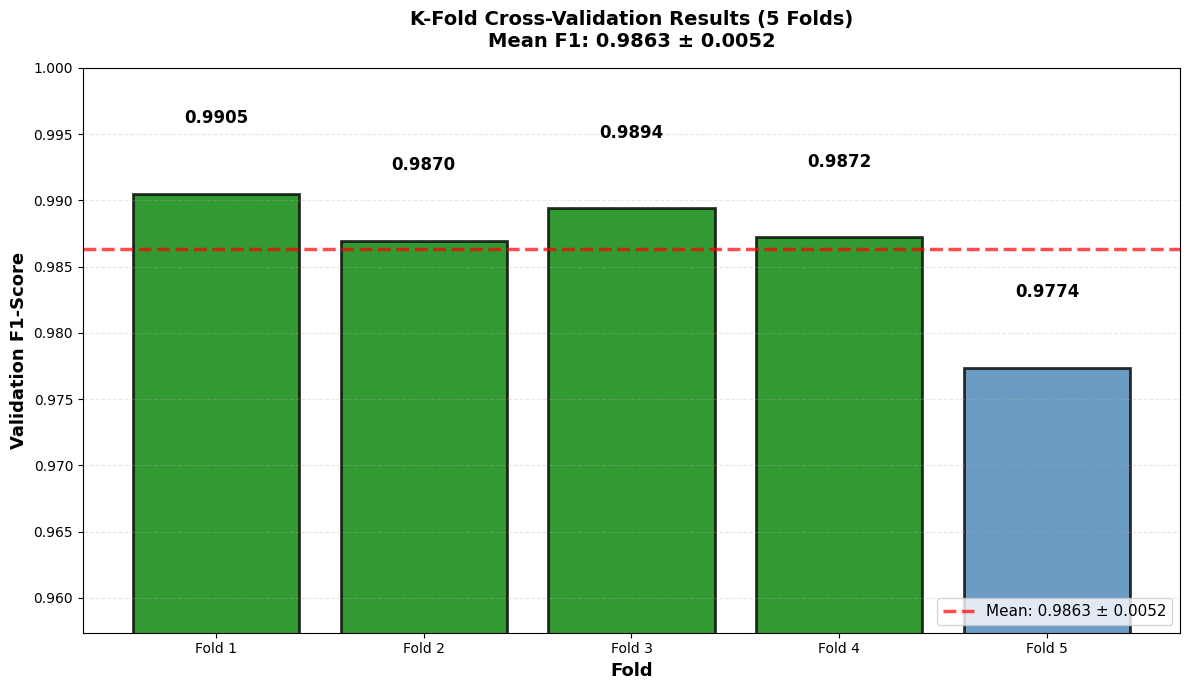

✅ Saved: kfold_f1_scores.png


/tmp/ipykernel_183/209636593.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_data, labels=['F1-Score', 'Precision', 'Recall'],


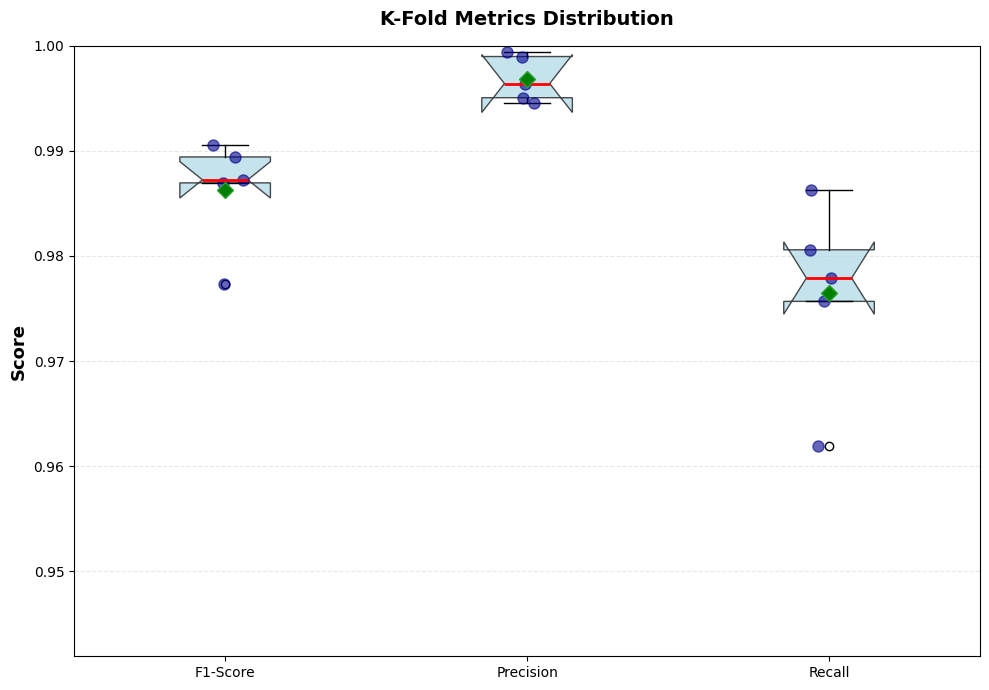

✅ Saved: kfold_boxplot.png


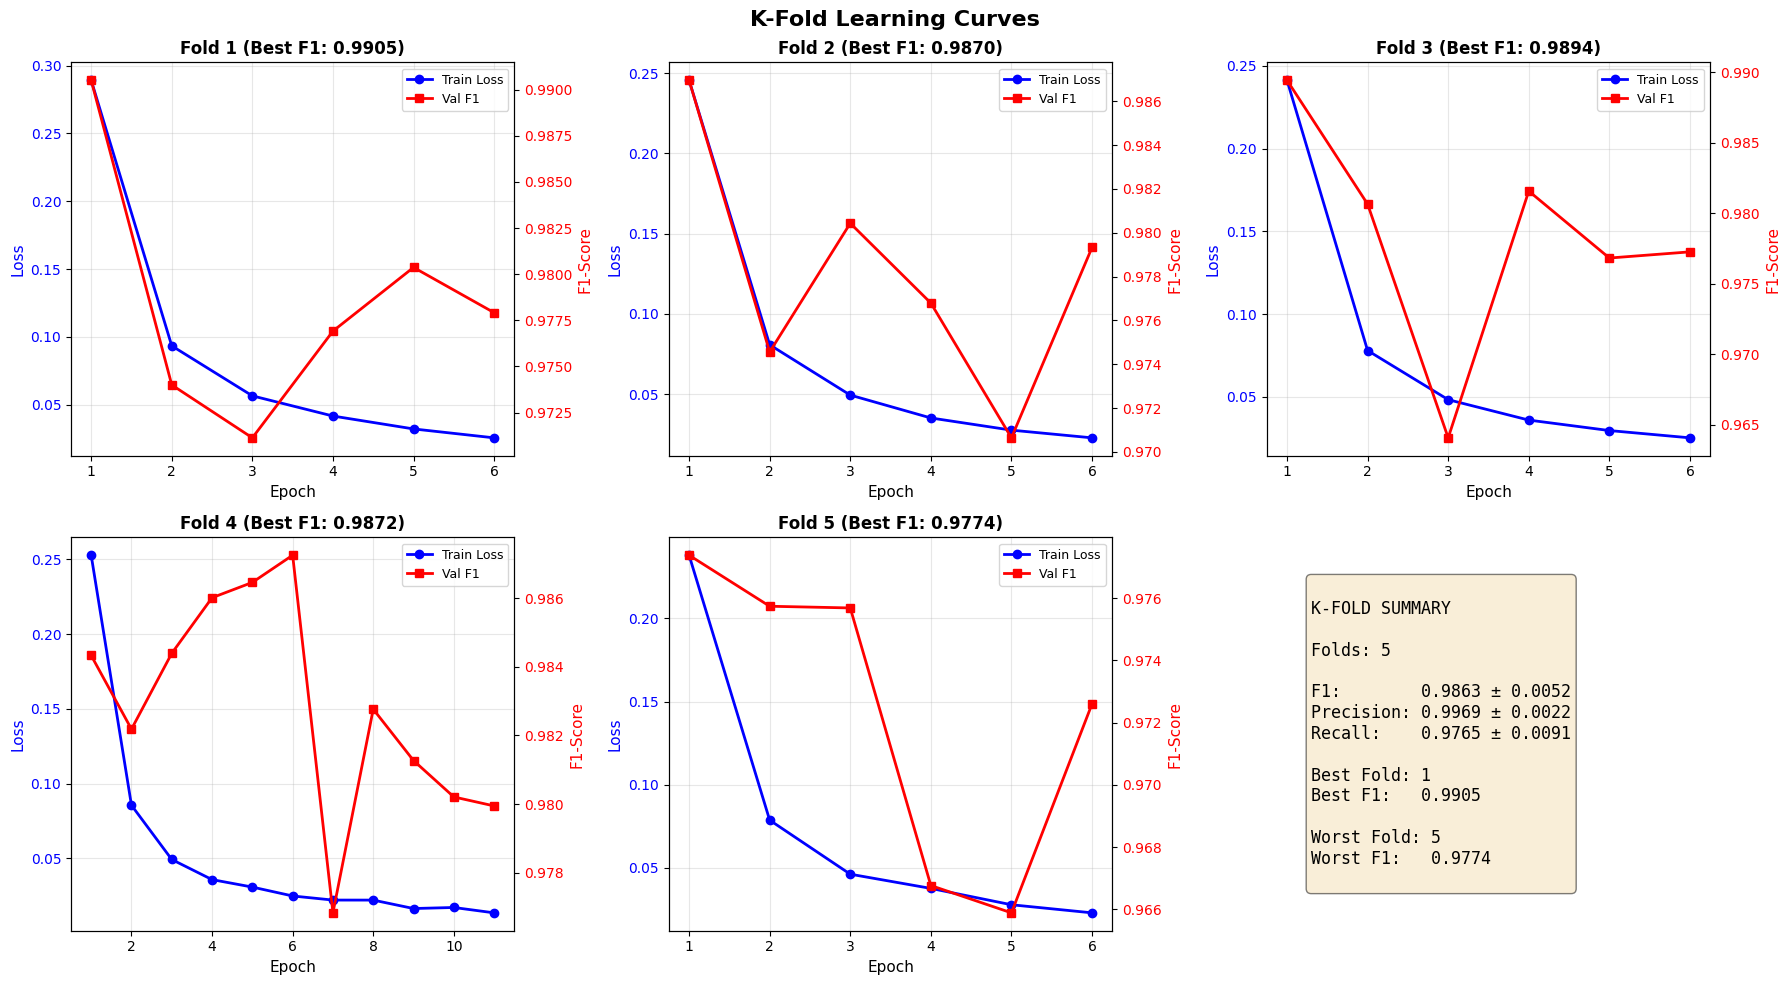

✅ Saved: kfold_learning_curves.png


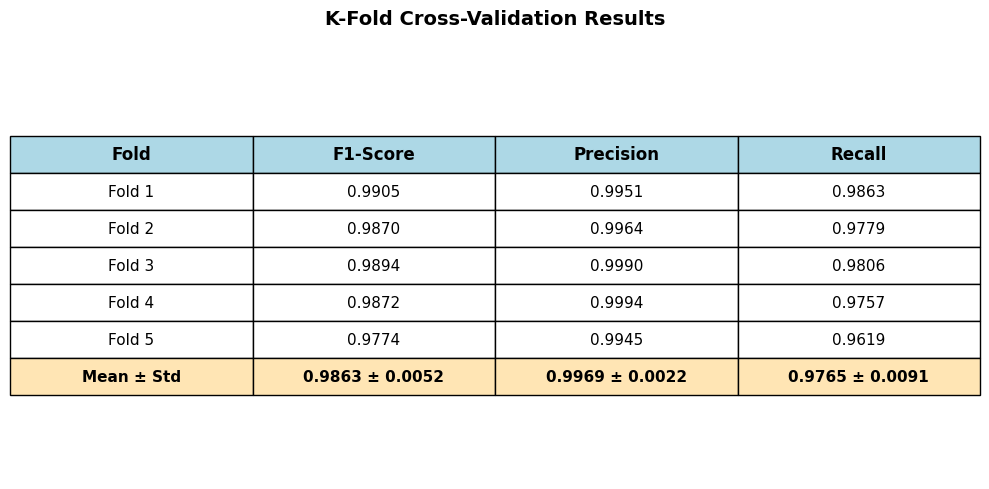

✅ Saved: kfold_results_table.png


In [21]:

print(f"\n{'='*80}")
print(f"GENERATING VISUALIZATIONS")
print(f"{'='*80}\n")

# PLOT 1: F1 Scores Bar Chart
fig, ax = plt.subplots(figsize=(12, 7))

folds = df_results['fold'].values
f1_scores = df_results['val_f1'].values
colors = ['green' if f1 >= mean_f1 else 'steelblue' for f1 in f1_scores]

bars = ax.bar(folds, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Mean line
ax.axhline(y=mean_f1, color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {mean_f1:.4f} ± {std_f1:.4f}', alpha=0.7)

# Add values on bars
for bar, f1 in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{f1:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation F1-Score', fontsize=13, fontweight='bold')
ax.set_title(f'K-Fold Cross-Validation Results (5 Folds)\nMean F1: {mean_f1:.4f} ± {std_f1:.4f}',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(folds)
ax.set_xticklabels([f'Fold {int(i)}' for i in folds])
ax.set_ylim([max(0.75, f1_scores.min()-0.02), min(1.0, f1_scores.max()+0.03)])
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('/kaggle/working/kfold_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: kfold_f1_scores.png")

# PLOT 2: Box Plot
fig, ax = plt.subplots(figsize=(10, 7))

metrics_data = [
    df_results['val_f1'].values,
    df_results['val_precision'].values,
    df_results['val_recall'].values
]

bp = ax.boxplot(metrics_data, labels=['F1-Score', 'Precision', 'Recall'],
                patch_artist=True, notch=True, showmeans=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

# Add individual points
for i, metric_vals in enumerate(metrics_data, 1):
    y = metric_vals
    x = np.random.normal(i, 0.04, size=len(y))
    ax.plot(x, y, 'o', alpha=0.6, color='darkblue', markersize=8)

ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('K-Fold Metrics Distribution', fontsize=14, fontweight='bold', pad=15)
ax.set_ylim([max(0.75, min([m.min() for m in metrics_data])-0.02), 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('/kaggle/working/kfold_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: kfold_boxplot.png")

# PLOT 3: Learning Curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

fig.suptitle('K-Fold Learning Curves', fontsize=16, fontweight='bold')

for fold_idx, ax in enumerate(axes[:5]):
    history = results_per_fold[fold_idx]['history']
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Dual axis
    ax2 = ax.twinx()
    
    line1 = ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2, marker='o')
    line2 = ax2.plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2, marker='s')
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11, color='b')
    ax2.set_ylabel('F1-Score', fontsize=11, color='r')
    ax.set_title(f'Fold {fold_idx+1} (Best F1: {results_per_fold[fold_idx]["val_f1"]:.4f})',
                fontweight='bold')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(alpha=0.3)
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right', fontsize=9)

# Summary in 6th subplot
ax_summary = axes[5]
ax_summary.axis('off')

summary_text = f"""
K-FOLD SUMMARY

Folds: {n_splits}

F1:        {mean_f1:.4f} ± {std_f1:.4f}
Precision: {mean_prec:.4f} ± {std_prec:.4f}
Recall:    {mean_rec:.4f} ± {std_rec:.4f}

Best Fold: {int(df_results.loc[df_results['val_f1'].idxmax(), 'fold'])}
Best F1:   {df_results['val_f1'].max():.4f}

Worst Fold: {int(df_results.loc[df_results['val_f1'].idxmin(), 'fold'])}
Worst F1:   {df_results['val_f1'].min():.4f}
"""

ax_summary.text(0.1, 0.5, summary_text, fontsize=12, fontfamily='monospace',
               verticalalignment='center', 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/kaggle/working/kfold_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: kfold_learning_curves.png")

# PLOT 4: Results Table
df_display = df_results.copy()
df_display['Fold'] = [f'Fold {int(i)}' for i in df_display['fold']]
df_display = df_display[['Fold', 'val_f1', 'val_precision', 'val_recall']]
df_display.columns = ['Fold', 'F1-Score', 'Precision', 'Recall']

# Format numbers
for col in ['F1-Score', 'Precision', 'Recall']:
    df_display[col] = df_display[col].apply(lambda x: f'{x:.4f}')

# Add summary row
summary_row = pd.DataFrame({
    'Fold': ['Mean ± Std'],
    'F1-Score': [f"{mean_f1:.4f} ± {std_f1:.4f}"],
    'Precision': [f"{mean_prec:.4f} ± {std_prec:.4f}"],
    'Recall': [f"{mean_rec:.4f} ± {std_rec:.4f}"]
})

df_display = pd.concat([df_display, summary_row], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df_display.values, colLabels=df_display.columns,
                cellLoc='center', loc='center', colColours=['lightblue']*4)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Bold header
for i in range(4):
    table[(0, i)].set_text_props(weight='bold', fontsize=12)

# Highlight summary row
for i in range(4):
    table[(6, i)].set_facecolor('#FFE5B4')
    table[(6, i)].set_text_props(weight='bold')

ax.set_title('K-Fold Cross-Validation Results', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('/kaggle/working/kfold_results_table.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: kfold_results_table.png")

In [22]:
# CSV
df_results.to_csv('/kaggle/working/kfold_results.csv', index=False)
print("✅ Saved: kfold_results.csv")

# JSON
import json

kfold_json = {
    'n_splits': n_splits,
    'mean_f1': float(mean_f1),
    'std_f1': float(std_f1),
    'mean_precision': float(mean_prec),
    'std_precision': float(std_prec),
    'mean_recall': float(mean_rec),
    'std_recall': float(std_rec),
    'best_fold': int(df_results.loc[df_results['val_f1'].idxmax(), 'fold']),
    'best_f1': float(df_results['val_f1'].max()),
    'folds': [
        {
            'fold': int(r['fold']),
            'f1': float(r['val_f1']),
            'precision': float(r['val_precision']),
            'recall': float(r['val_recall'])
        } for r in results_per_fold
    ]
}

with open('/kaggle/working/kfold_results.json', 'w') as f:
    json.dump(kfold_json, f, indent=2)
print("✅ Saved: kfold_results.json")

print(f"\n{'='*80}")
print(f"✅ K-FOLD COMPLETE!")
print(f"{'='*80}")

✅ Saved: kfold_results.csv
✅ Saved: kfold_results.json

✅ K-FOLD COMPLETE!
